In [119]:
import os
import numpy as np
import pandas as pd
import torch
import csv
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
project_path = "/content/drive/MyDrive/Colab/SRL/"


In [120]:
sentences = []
rel_tags = []
srl_tags = []
csv_file = project_path + "output_drel_dataset.csv"
with open(csv_file, 'r', encoding='utf-8') as file:
    csv_reader = csv.reader(file)
    next(csv_reader)
    for row in csv_reader:
        sentence, rel, srl = row
        words = sentence.split()
        rel_list = rel.split()
        srl_list = srl.split()
        sentences.append(words)
        rel_tags.append(rel_list)
        srl_tags.append(srl_list)

In [13]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/wiki.hi.bin

--2024-05-08 17:17:15--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/wiki.hi.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.14, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2024-05-08 17:17:15 ERROR 403: Forbidden.



In [118]:
!pip install fasttext
import fasttext
import fasttext.util

In [24]:
fasttext.util.download_model('hi', if_exists='ignore')  # hi

'cc.hi.300.bin'

In [25]:
ft = fasttext.load_model('cc.hi.300.bin')

In [68]:
print(len(sentences[0]))
print(len(srl_tags[0]))

18
18


In [38]:
def GetFTEmbeddings(sentence):
    embed = []
    for i, w in enumerate(sentence):
        embed.append(ft.get_word_vector(w))
    return torch.tensor(embed)

In [37]:
print(len(sentences[0]))
print(len(GetFTEmbeddings(sentences[0])))
# print(ft.get_word_vector(sentences[0][1]))
tmp = torch.tensor(GetFTEmbeddings(sentences[0]))
print(tmp.shape)
print(tmp)

18
18
torch.Size([18, 300])
tensor([[-0.0328, -0.0100,  0.0359,  ...,  0.0052,  0.0536,  0.0243],
        [-0.0159,  0.0893,  0.0970,  ...,  0.0294,  0.0963,  0.0223],
        [ 0.1644, -0.2193,  0.1713,  ..., -0.1537,  0.0747,  0.0110],
        ...,
        [-0.0158, -0.0204,  0.0031,  ..., -0.0078,  0.0752, -0.0231],
        [-0.0084,  0.0049,  0.0380,  ..., -0.0005,  0.0400, -0.0468],
        [-0.0576,  0.0033,  0.0193,  ..., -0.0050, -0.0436,  0.0253]])


In [5]:
print(srl_tags)

[['ARGM-TMP', 'NO_SRL', 'ARG2-ATR', 'ARG1', 'NO_SRL', 'NO_SRL', 'ARGM-DIS', 'ARGM-LOC', 'ARG1', 'ARG2-ATR', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'ARGM-LOC', 'ARG1', 'ARGM-MNR', 'ARG2-ATR', 'NO_SRL'], ['ARGM-TMP', 'ARG0', 'NO_SRL', 'ARG1', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'ARG0', 'NO_SRL', 'ARG1', 'NO_SRL'], ['NO_SRL', 'ARGM-LOC', 'NO_SRL', 'ARG1', 'NO_SRL'], ['ARG1', 'ARGM-MNR', 'NO_SRL', 'ARG2-ATR', 'NO_SRL'], ['NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'ARG1', 'NO_SRL', 'NO_SRL', 'ARG0', 'NO_SRL', 'NO_SRL'], ['NO_SRL', 'NO_SRL', 'ARGM-LOC', 'ARGM-MNR', 'NO_SRL', 'NO_SRL', 'ARG1', 'ARGM-TMP', 'NO_SRL', 'NO_SRL', 'ARGM-CAU', 'ARG1', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL'], ['NO_SRL', 'NO_SRL', 'ARG1', 'ARG2-ATR', 'NO_SRL'], ['NO_SRL', 'NO_SRL', 'NO_SRL', 'ARGM-LOC', 'ARG0', 'NO_SRL', 'ARG1', 'NO_SRL', 'ARG1', 'ARG2-ATR', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'NO_SRL', 'ARG1', 'NO_SRL', 'NO_SRL', 'ARGM-LOC', 'ARG2-ATR', 'NO_SRL'], ['NO_SR

In [121]:
# labels = ["ARG0","ARG1","ARG2","ARG3","ARG2-ATR","ARG2-LOC","ARG2-GOL","ARG2-SOU","ARGM-PRX","ARGM-ADV",
#         "ARGM-DIR","ARGM-EXT","ARGM-MNR","ARGM-PRP","ARGM-DIS","ARGM-LOC","ARGM-MNS","ARGM-NEG","ARGM-TMP",
#           "ARGM-CAU", "NO_SRL"]
A = set()
for arr in srl_tags:
    for tag in arr:
        A.add(tag)
labels = list(A)
label_dict = {label: index for index, label in enumerate(labels)}

B = set()
for arr in rel_tags:
    for tag in arr:
        B.add(tag)
rel_labels = list(B)
rel_dict = {label: index for index, label in enumerate(rel_labels)}

In [126]:
print(srl_tags[0][2])
print(rel_tags[0][2])
print(sentences[0][2])
print(label_dict['NO_SRL'])
print(label_dict)

ARG2-ATR
k7
मन
17
{'ARGM-DIS': 0, 'ARGM-ADV': 1, 'ARG-UNDEF': 2, 'ARGM-DIR': 3, 'ARGM-MOD': 4, 'ARG2': 5, 'ARGM-EXT': 6, 'ARG2-GOL': 7, 'ARGM-LOC': 8, 'ARG2-ATR': 9, 'ARGM-MNR': 10, 'ARG3': 11, 'ARG1': 12, 'ARG2-LOC': 13, 'ARGM-MNS': 14, 'ARG0': 15, 'ARGM-PRX': 16, 'NO_SRL': 17, 'ARGM-CAU': 18, 'ARG2-SOU': 19, 'ARGM-TMP': 20, 'ARGM-NEG': 21, 'ARGM-PRP': 22}


In [127]:
rel_indices = []
label_indices = []
for i, sent in enumerate(sentences):
    # s_t = [2]
    # srl = [label_dict['NO_SRL']]
    srl = []
    rel = []
    for j, w in enumerate(sent):
        # w_t = tokenizer.encode(w, add_special_tokens=False)
        # max_enc = max(max_enc, len(w_t))
        # s_t.extend(w_t)
        srl.extend([label_dict[srl_tags[i][j]]])
        rel.extend([rel_dict[rel_tags[i][j]]])
    label_indices.append(srl)
    rel_indices.append(rel)

In [152]:
Xtrain = sentences[:-300]
Xtrain_rel = rel_indices[:-300]
Ytrain = label_indices[:-300]

Xtest = sentences[-300:]
Xtest_rel = rel_indices[-300:]
Ytest = label_indices[-300:]

In [84]:
print(len(Ytrain[0]))

18


In [ ]:
print(type(Xtrain))

<class 'list'>


---
---

<br>


In [134]:
class SRLClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_rels, rel_emb_dim):
        super(SRLClassifier, self).__init__()
        self.RelEmbeddings = nn.Embedding(num_rels, rel_emb_dim)
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim + rel_emb_dim, hidden_dim // 2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, rel):
        rel_emb = self.RelEmbeddings(rel)
        # print("x_dim - ", x.shape)
        # print("rel_dim - ", rel_emb.shape)
        x = torch.cat((x, rel_emb), dim=2)
        # print("x cat dim - ", x.shape)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out.contiguous().view(-1, self.hidden_dim))
        return out

In [135]:
input_dim = 300
rel_emb_dim = 100
hidden_dim = 32
output_dim = len(label_dict)
srl_classifier = SRLClassifier(input_dim, hidden_dim, output_dim, len(rel_dict), rel_emb_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(srl_classifier.parameters(), lr = 0.001)

In [ ]:
# batch_size = 32
# train_dataset = [(getEmbedding(sent), label) for sent, label in zip(Xtrain[:100], Ytrain[:100])]
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [136]:
def trainClassifier(classifier, Xtrain, Xtrain_rel, Ytrain, n_epochs, optimizer):
    losses = []
    for epoch in range(n_epochs):
        classifier.train()
        running_loss = 0.0
        with tqdm(total=len(Xtrain), desc=f"Epoch {epoch+1}/{n_epochs}") as pbar:
            i = 0
            for sent, rel_tags, labels in zip(Xtrain, Xtrain_rel, Ytrain):
                optimizer.zero_grad()
                # encoded_sent = getEmbedding(sent, mask = train_masks[i])
                encoded_sent = GetFTEmbeddings(sent)
                encoded_sent = encoded_sent.reshape(1, encoded_sent.size(0), encoded_sent.size(1))
                # print("x shape - ", encoded_sent.shape)
                encoded_sent = encoded_sent.to(device)
                rel = torch.tensor(rel_tags).to(device)
                rel = rel.reshape(1, rel.size(0))
                # print("rel shape - ", rel.shape)
                targets = torch.tensor(labels).to(device)
                targets = targets.reshape(1, targets.size(0))
                # print("y shape - ", targets.shape)
                outputs = classifier(encoded_sent, rel).to(device)
                reshaped_outputs = outputs.view(-1, outputs.size(-1))
                reshaped_targets = targets.view(-1)
                loss = criterion(reshaped_outputs, reshaped_targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                pbar.update(1)
                i += 1
        epoch_loss = running_loss / len(Xtrain)
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1}, Loss: {epoch_loss}\n")
    return losses

In [137]:
losses = trainClassifier(srl_classifier, Xtrain, Xtrain_rel, Ytrain, 10, optimizer)

Epoch 1/10: 100%|██████████| 1007/1007 [00:02<00:00, 341.62it/s]


Epoch 1, Loss: 0.9525945652738702



Epoch 2/10: 100%|██████████| 1007/1007 [00:03<00:00, 270.66it/s]


Epoch 2, Loss: 0.6023144296665474



Epoch 3/10: 100%|██████████| 1007/1007 [00:03<00:00, 306.30it/s]


Epoch 3, Loss: 0.5307955766705261



Epoch 4/10: 100%|██████████| 1007/1007 [00:02<00:00, 340.55it/s]


Epoch 4, Loss: 0.48869622336902174



Epoch 5/10: 100%|██████████| 1007/1007 [00:02<00:00, 336.99it/s]


Epoch 5, Loss: 0.4582996281305959



Epoch 6/10: 100%|██████████| 1007/1007 [00:03<00:00, 289.63it/s]


Epoch 6, Loss: 0.4315857306352142



Epoch 7/10: 100%|██████████| 1007/1007 [00:03<00:00, 276.86it/s]


Epoch 7, Loss: 0.40611262963539085



Epoch 8/10: 100%|██████████| 1007/1007 [00:02<00:00, 344.65it/s]


Epoch 8, Loss: 0.3822797407602379



Epoch 9/10: 100%|██████████| 1007/1007 [00:02<00:00, 340.41it/s]


Epoch 9, Loss: 0.36028197105204485



Epoch 10/10: 100%|██████████| 1007/1007 [00:03<00:00, 321.41it/s]

Epoch 10, Loss: 0.33970533802415415



In [138]:
print(losses)

[0.9525945652738702, 0.6023144296665474, 0.5307955766705261, 0.48869622336902174, 0.4582996281305959, 0.4315857306352142, 0.40611262963539085, 0.3822797407602379, 0.36028197105204485, 0.33970533802415415]


In [ ]:
print(Xtrain)
print(Ytrain)

[[2, 21701, 1134, 1520, 1976, 1520, 1301, 13700, 2022, 1883, 1883, 1134, 29366, 122028, 11611, 524, 655, 17132, 4384, 5478, 9017, 16271, 1546, 2344, 45665, 4765, 10759, 69066, 80134, 8, 158450, 4384, 1603, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 113468, 93474, 73061, 41670, 1301, 13700, 128547, 1793, 13577, 100705, 339, 2344, 45665, 87033, 93474, 73061, 41670, 1603, 37766, 58125, 22432, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 25397, 1976, 2344, 45665, 4765, 10759, 37766, 58125, 4384, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [2, 2344, 45665, 25397, 1976, 4674, 2525, 25431, 4384, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [139]:
def saveModel(model, path):
    torch.save(model.state_dict(), path)

def loadModel(model, path):
    if device == 'cuda':
        model.load_state_dict(torch.load(path))
    else:
        model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

In [140]:
saveModel(srl_classifier, project_path + "classifier4.pt")

In [ ]:
# out = srl_classifier(xt.unsqueeze(0))

In [166]:
y_test_pred_total = []
y_test_true_total = []

In [164]:
def evaluate(classifier, Xtest, Xtest_rel, Ytest):
    classifier.eval()
    total_samples = 0
    correct_samples = 0
    with torch.no_grad():
        for i, (sent, rel_tags, true_labels) in enumerate(zip(Xtest, Xtest_rel, Ytest)):
            encoded_sent = GetFTEmbeddings(sent)
            inputs = encoded_sent.unsqueeze(0).to(device)
            rel = torch.tensor(rel_tags).to(device)
            rel = rel.reshape(1, rel.size(0))
            # print("input shape -", inputs.shape)
            # print("rel shape -", rel.shape)
            targets = torch.tensor(true_labels).to(device)
            outputs = classifier(inputs, rel).to(device)
            predicted_labels = outputs.max(dim=1)[1].view(-1)
            total_samples += len(true_labels)
            # print("predicted - ", predicted_labels)
            # print("true - ", true_labels)
            correct_samples += (predicted_labels == targets).sum().item()
            y_test_pred_total.extend(predicted_labels.cpu().numpy())
            y_test_true_total.extend(targets.cpu().numpy())
            # break
    test_accuracy = correct_samples / total_samples
    return test_accuracy

In [167]:
a1 = evaluate(srl_classifier, Xtest, Xtest_rel, Ytest)

In [169]:
print(y_test_pred_total[0])
print(y_test_true_total[0])

8
8


In [172]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test_true_total, y_test_pred_total))

              precision    recall  f1-score   support

           0       0.40      0.25      0.31        24
           1       0.00      0.00      0.00        23
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         1
           5       0.67      0.62      0.65        32
           6       0.00      0.00      0.00        23
           7       0.71      0.56      0.63        18
           8       0.66      0.83      0.74       163
           9       0.78      0.74      0.76        84
          10       0.44      0.55      0.49        74
          11       0.00      0.00      0.00         1
          12       0.81      0.87      0.84       415
          13       0.00      0.00      0.00        12
          14       0.31      0.36      0.33        11
          15       0.82      0.77      0.80       227
          17       0.97      0.95      0.96      2084
          18       0.35      0.35      0.35        17
          19       0.30    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [163]:
print(Ytest[0])

[8, 17, 17, 17, 17, 17, 12, 17]


In [157]:
print(a1)

0.8686109440769694


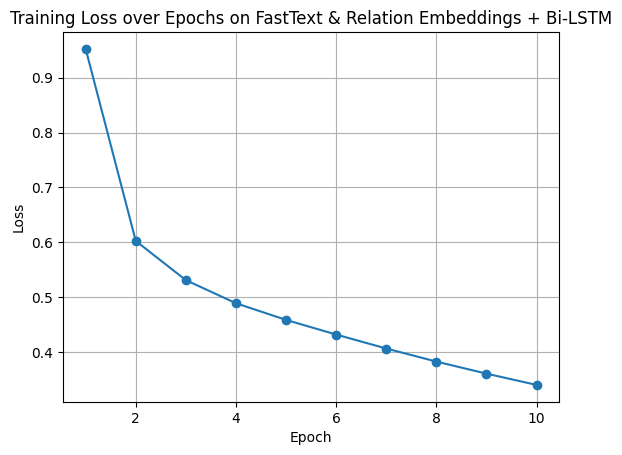

In [159]:
import matplotlib.pyplot as plt
# Plot the losses
plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-')
plt.title('Training Loss over Epochs on FastText & Relation Embeddings + Bi-LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()